In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Generate sample data for Wind Direction
with pm.Model() as direction_speed_sampler:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=.5, sigma=.2, transform=direction_transform)

    # Generate the observed data for Wind Direction
    #direction_observed = pm.Normal('direction_observed', mu=direction, sigma=0.1, observed=np.random.randn(100))

    # Generate sample data for Wind Speed

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=10)

    # Generate the observed data for Wind Speed
    #speed_observed = pm.Normal('speed_observed', mu=speed, sigma=0.1, observed=np.random.randn(100))


In [3]:

def xr_downselect(xr_orig, coordinate, step):
    return xr_orig.sel({f'{coordinate}':xr_orig[f'{coordinate}']%step==0})


In [4]:
with direction_speed_sampler:
    samples = pm.sample(10, chains=1, tune=1000)


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [direction, speed]


Sampling 1 chain for 1_000 tune and 10 draw iterations (1_000 + 10 draws total) took 2 seconds.
The number of samples is too small to check convergence reliably.


In [5]:
samples

Inference data with groups:
	> posterior
	> sample_stats

In [6]:
direction_observed = samples.posterior.direction
speed_observed = samples.posterior.speed

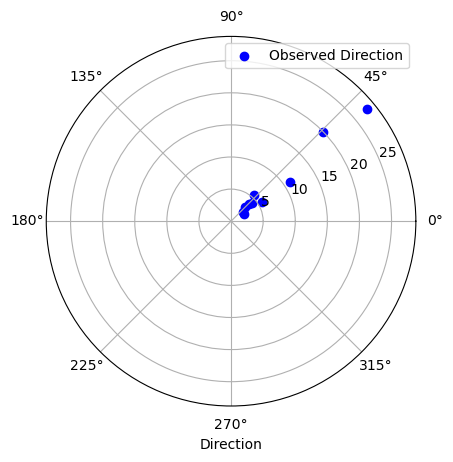

In [7]:

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction')

# Plot the observed speed
#ax.scatter(speed_observed, np.ones_like(speed_observed), c='red', label='Observed Speed')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


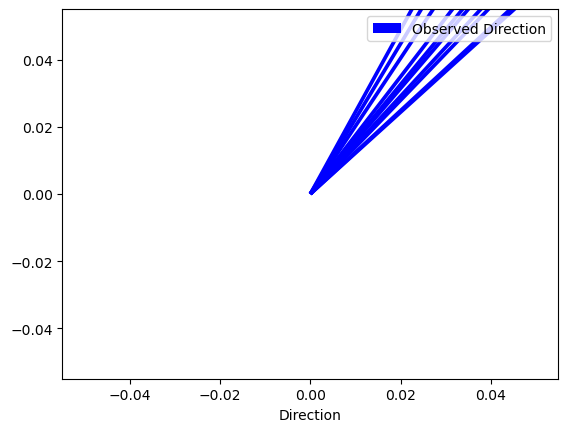

In [8]:


# Create a polar plot
fig, ax = plt.subplots()#subplot_kw={'projection': 'polar'})
# Convert polar coordinates to Cartesian coordinates
arrow_x = speed_observed * np.sin(direction_observed)
arrow_y = speed_observed * np.cos(direction_observed)


# Plot the observed direction as arrows pointing towards the center
ax.quiver(np.zeros_like(arrow_x), np.zeros_like(arrow_y), arrow_x, arrow_y,  angles='uv', scale_units='x', scale=1, color='blue', label='Observed Direction')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [9]:
# Set up priors for wind direction and speed
pr_mu_direction = 0
pr_sigma_direction = 0.1

pr_sigma_speed = 1

# currently uncorrelated speed and direction
with pm.Model() as direction_speed_model:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=pr_mu_direction, sigma=pr_sigma_direction, transform=direction_transform)

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=pr_sigma_speed)

    # Generate the observed data for Wind Direction
    direction_obs = pm.Normal('direction_obs', mu=direction, sigma=0.1, observed=direction_observed)

    # Generate the observed data for Wind Speed
    speed_obs = pm.HalfNormal('speed_obs', sigma=speed, observed=speed_observed)



In [10]:
with direction_speed_model:
    trace = pm.sample(1000)
trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [direction, speed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

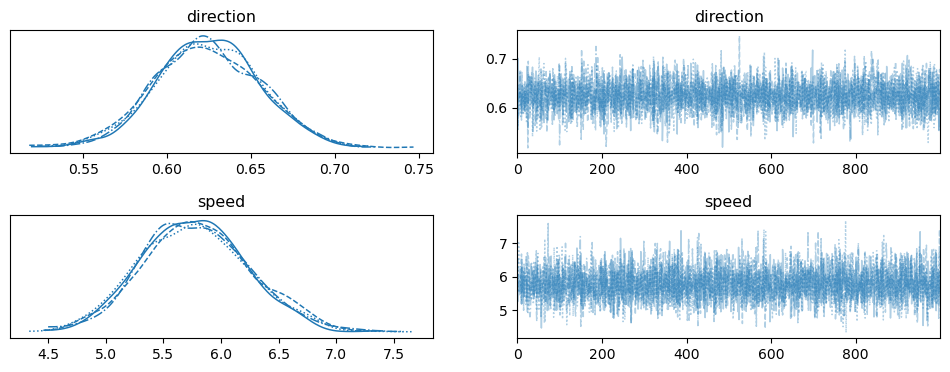

In [11]:
pm.plot_trace(trace, var_names=['direction', 'speed'])
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
plt.show()


In [12]:
with direction_speed_model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)
    trace.extend(posterior_predictive)


Sampling: [direction_obs, speed_obs]


In [50]:
downsampled_trace.direction_obs.squeeze()


<xarray.DataArray 'direction_obs' (chain: 4, draw: 200, direction_obs_dim_3: 10)>
array([[[0.47539501, 0.70462483, 0.49761692, ..., 0.69682262,
         0.77240441, 0.61923719],
        [0.70918929, 0.67957918, 0.68558762, ..., 0.56052405,
         0.62488058, 0.48176116],
        [0.70194041, 0.36501173, 0.67129734, ..., 0.61630969,
         0.58424497, 0.58810683],
        ...,
        [0.64342733, 0.62430342, 0.45624736, ..., 0.61115746,
         0.65479552, 0.78013498],
        [0.51573164, 0.67405607, 0.5976926 , ..., 0.68722942,
         0.67799599, 0.69995   ],
        [0.51538124, 0.62982896, 0.55993457, ..., 0.54879285,
         0.5509047 , 0.54076169]],

       [[0.70830695, 0.7802171 , 0.652247  , ..., 0.79284086,
         0.87828031, 0.70197058],
        [0.67230862, 0.68235794, 0.65273805, ..., 0.50043537,
         0.61334904, 0.63400927],
        [0.61442639, 0.80530642, 0.71984176, ..., 0.52987035,
         0.48616497, 0.43912504],
...
        [0.54594218, 0.6773931 , 0.46918643, ..., 0.56019527,
         0.50089036, 0.63993294],
        [0.66285052, 0.614227  , 0.5583074 , ..., 0.60530462,
         0.53912532, 0.69879507],
        [0.6286066 , 0.54094305, 0.66126365, ..., 0.44135196,
         0.68547868, 0.56084552]],

       [[0.87005136, 0.67298563, 0.6780543 , ..., 0.50881696,
         0.54581812, 0.6391872 ],
        [0.57558298, 0.7913067 , 0.66067018, ..., 0.5313833 ,
         0.39667308, 0.58877244],
        [0.5315596 , 0.65593059, 0.6963276 , ..., 0.6394852 ,
         0.60418416, 0.83880491],
        ...,
        [0.66157161, 0.60614951, 0.44619428, ..., 0.70356658,
         0.61062037, 0.72994304],
        [0.80932653, 0.57938627, 0.57002977, ..., 0.56073807,
         0.59857993, 0.7093186 ],
        [0.75116619, 0.81056268, 0.78770913, ..., 0.75684662,
         0.51749718, 0.55354437]]])
Coordinates:
  * chain                (chain) int32 0 1 2 3
  * draw                 (draw) int32 0 5 10 15 20 25 ... 975 980 985 990 995
    direction_obs_dim_2  int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
    speed_obs_dim_2      int32 0

In [35]:
# Downsample the trace.posterior using xarray
downsampled_trace = xr_downselect(trace.posterior_predictive, 'draw', 5).squeeze()

# Print the downsampled trace
print(downsampled_trace)


<xarray.Dataset>
Dimensions:              (chain: 4, draw: 200, direction_obs_dim_3: 10,
                          speed_obs_dim_3: 10)
Coordinates:
  * chain                (chain) int32 0 1 2 3
  * draw                 (draw) int32 0 5 10 15 20 25 ... 975 980 985 990 995
    direction_obs_dim_2  int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
    speed_obs_dim_2      int32 0
  * speed_obs_dim_3      (speed_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    direction_obs        (chain, draw, direction_obs_dim_3) float64 0.4754 .....
    speed_obs            (chain, draw, speed_obs_dim_3) float64 6.161 ... 9.545
Attributes:
    created_at:                 2023-12-23T03:55:21.674056
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.2


In [68]:
downsampled_trace['direction_obs'].sel({'chain':2})

<xarray.DataArray 'direction_obs' (draw: 200, direction_obs_dim_3: 10)>
array([[0.69248472, 0.78135154, 0.36709108, ..., 0.6054794 , 0.74255803,
        0.6108206 ],
       [0.82240702, 0.61338416, 0.72500157, ..., 0.63192444, 0.79838833,
        0.67472311],
       [0.53419559, 0.56512798, 0.44903115, ..., 0.48950618, 0.76075705,
        0.75381151],
       ...,
       [0.54594218, 0.6773931 , 0.46918643, ..., 0.56019527, 0.50089036,
        0.63993294],
       [0.66285052, 0.614227  , 0.5583074 , ..., 0.60530462, 0.53912532,
        0.69879507],
       [0.6286066 , 0.54094305, 0.66126365, ..., 0.44135196, 0.68547868,
        0.56084552]])
Coordinates:
    chain                int32 2
  * draw                 (draw) int32 0 5 10 15 20 25 ... 975 980 985 990 995
    direction_obs_dim_2  int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
    speed_obs_dim_2      int32 0

C:\Users\willi\AppData\Local\Temp\ipykernel_4040\3079054372.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


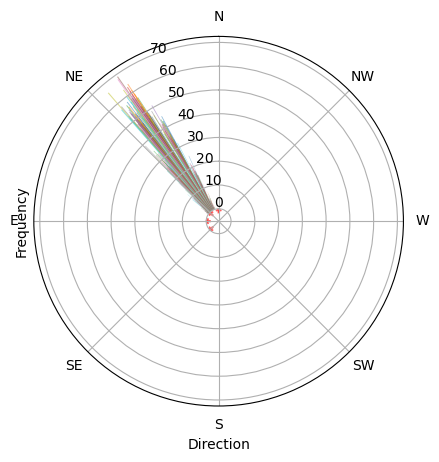

In [80]:
import numpy as np

# Create a polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')

# Plot the histogram with the direction offset for each chain
for chain in downsampled_trace['direction_obs'].chain:
    ax.hist((downsampled_trace['direction_obs'].sel({'chain':chain})) % (2 * np.pi), bins=10, alpha=0.5)
    arr_CM = plt.arrow(chain*45*np.pi/180, -1.7, 0.0, 1, color='red', width=0.1, head_width=0.5, alpha=0.5)

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('Frequency')

# Set the direction labels
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


# Show the plot
plt.show()


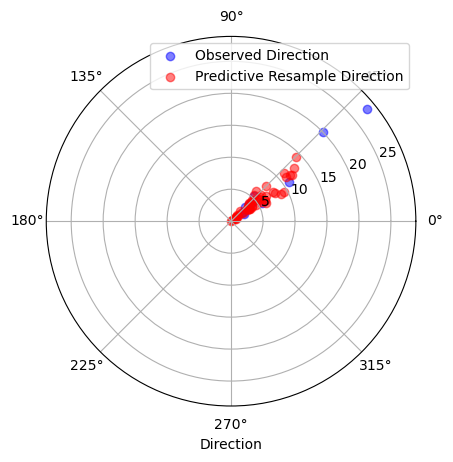

In [18]:
# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction', alpha=0.5)

#plot the posterior predictive
ax.scatter(downsampled_trace['direction_obs'], downsampled_trace['speed_obs'], c='red', label='Predictive Resample Direction', alpha=0.5)

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


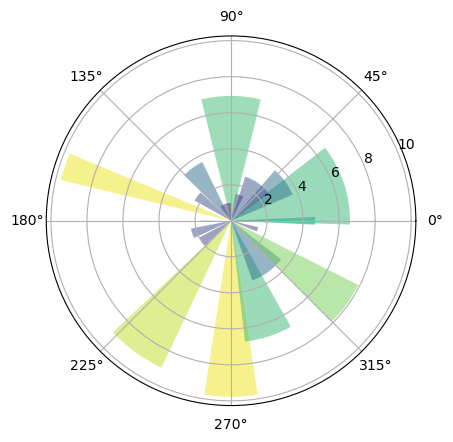

In [15]:
# Compute pie slices
N = 20
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
colors = plt.cm.viridis(radii / 10.)

ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.5)

plt.show()